# Import_Libraries

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import ipykernel


In [7]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed = 123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1212 files belonging to 6 classes.


In [9]:
class_names = dataset.class_names

In [10]:
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [11]:
len(dataset)

38

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy)
    print(labels_batch.numpy())


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        ...,
        [241.40625, 241.40625, 241.40625],
        [245.15625, 245.15625, 245.15625],
        [255.     , 255.     , 255.     ]],

       [[255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        ...,
        [241.40625, 241.40625, 241.40625],
        [245.15625, 245.15625, 245.15625],
        [255.     , 255.     , 255.     ]],

       [[255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        ...,
        [241.40625, 241.40625, 241.40625],
        [245.15625, 245.15625, 245.15625],
        [255.     , 255.     , 255.     ]],

       ...,

       [[255.     , 255.     , 255.     ],
        [255.     , 255.     ,

## Visualization

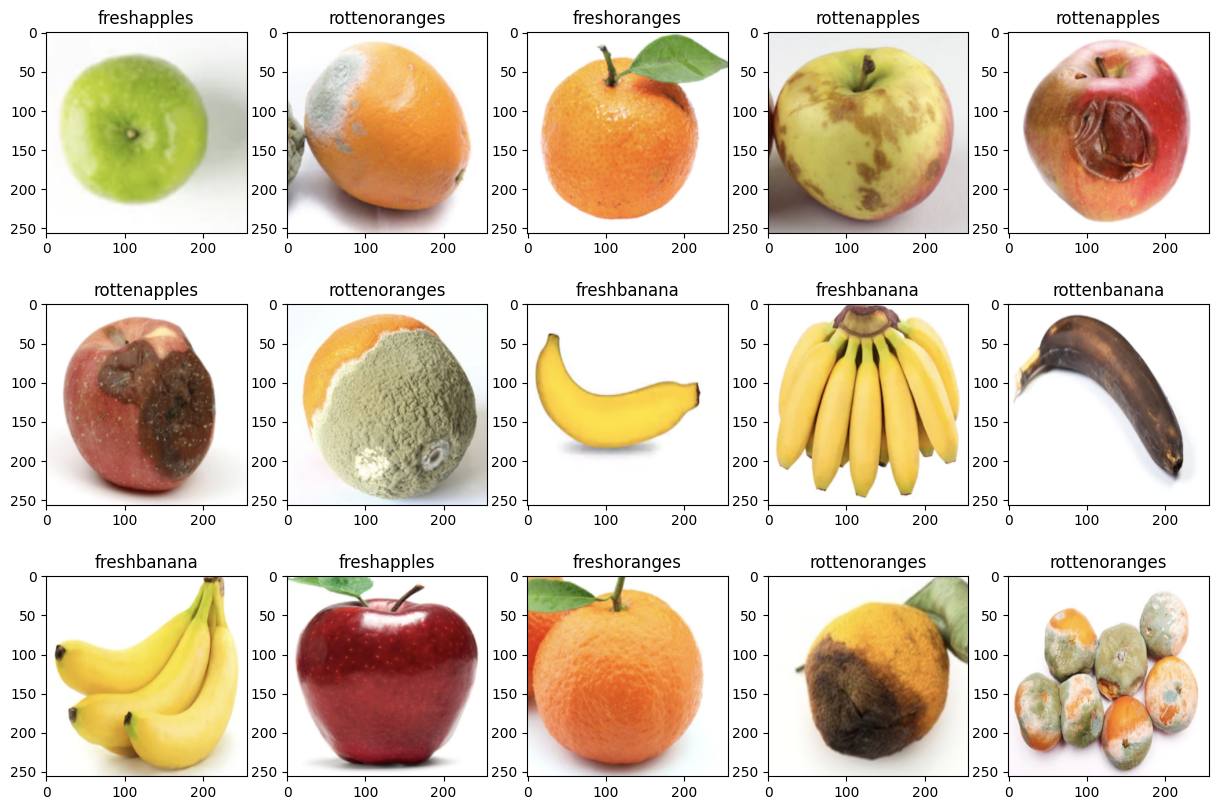

In [13]:
plt.figure(figsize=(15,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])

Dataset ds  are divided into three category.
1. 80% of the data for model training.--train_split
2. 10% of the data for model testing.--test_split
3. 10% of the data for validation.---val_split
shuffle_size = 10000

In [14]:
def get_dataset(ds, train_split=0.80, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split)==1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [15]:
test_ds = get_dataset(dataset)

In [16]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [17]:
print(train_ds)
print(val_ds)
print(test_ds)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [18]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

30
3
5


### shuffle_data

In [19]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

### building cnn_model

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Apply data augmentation on training data


In [22]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### model

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6 #  3*2(apple orange banana * rotten fresh)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    #2nd_layer
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #3rd_layer
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #4th_layer
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    #5th_layer
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    #6th_layer
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    #convert 2D to 1D
    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compaling the model

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
30/30 [==============================] - 87s 2s/step - loss: 1.7124 - accuracy: 0.2887 - val_loss: 1.4817 - val_accuracy: 0.4062
Epoch 2/5
30/30 [==============================] - 68s 2s/step - loss: 1.3332 - accuracy: 0.4540 - val_loss: 1.0906 - val_accuracy: 0.5312
Epoch 3/5
30/30 [==============================] - 65s 2s/step - loss: 1.0740 - accuracy: 0.5617 - val_loss: 1.0709 - val_accuracy: 0.4896
Epoch 4/5
30/30 [==============================] - 65s 2s/step - loss: 0.9783 - accuracy: 0.6088 - val_loss: 0.9461 - val_accuracy: 0.5417
Epoch 5/5
30/30 [==============================] - 66s 2s/step - loss: 0.8542 - accuracy: 0.6841 - val_loss: 0.6804 - val_accuracy: 0.7917


In [27]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 5s 556ms/step - loss: 0.8465 - accuracy: 0.7000


In [28]:
scores #Scores is just a list containing loss and accuracy value

[0.8464808464050293, 0.699999988079071]

## Plotting the Accuracy and Loss Curves

In [29]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 5, 'steps': 30}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [30]:

print(type(history.history['loss']))
print(len(history.history['loss']))

<class 'list'>
5


In [31]:
history.history['loss'][:5]

[1.7124252319335938,
 1.3331793546676636,
 1.0740097761154175,
 0.9783303737640381,
 0.854154109954834]

In [32]:
accuracy=history.history['accuracy']
validation_accuracy=history.history['val_accuracy']

loss=history.history['loss']
validation_loss=history.history['val_loss']

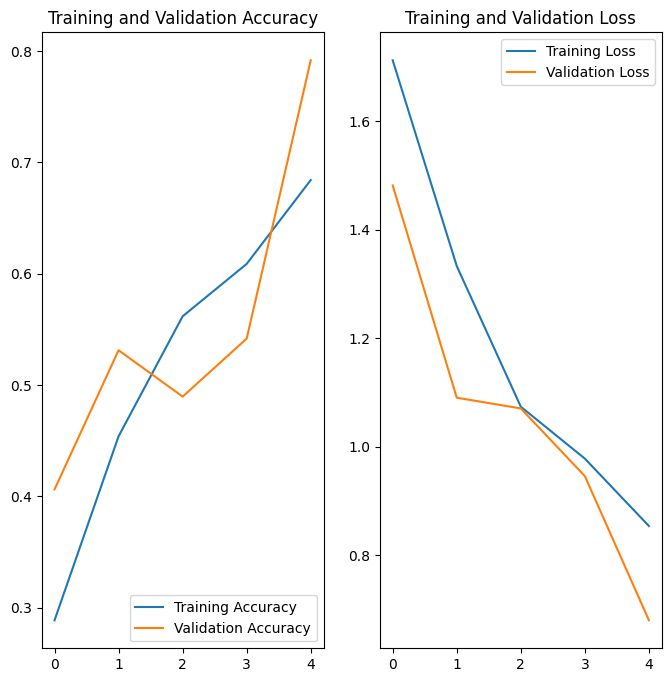

In [33]:
epochs=5
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
import sklearn

In [35]:
mythreshold = 0.2
from sklearn.metrics import confusion_matrix


In [41]:
# y_pred = model.predict(test_ds)
# y_pred = (y_pred > 0.2)
# cm = confusion_matrix( train_ds , y_pred)

#### Run prediction on a sample image

first image to predict
actual label: rottenoranges
1/1 [==============================] - 1s 1s/step
predicated label: freshbanana


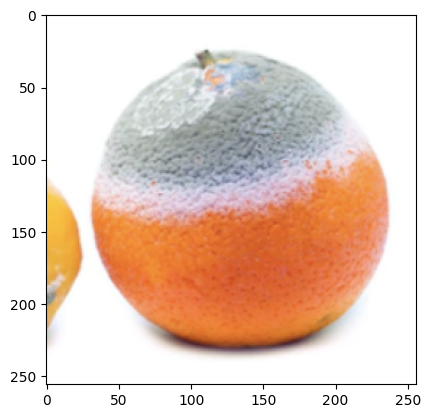

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_predication=model.predict(images_batch)
    print('predicated label:', class_names[np.argmax(batch_predication[0])])

#### Write a function for inference

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predication = model.predict(img_array)
    
    predicated_class = class_names[np.argmax(predication[0])]
    confidence = round(100*(np.max(predication[0])),2)
    return predicated_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 101ms/step


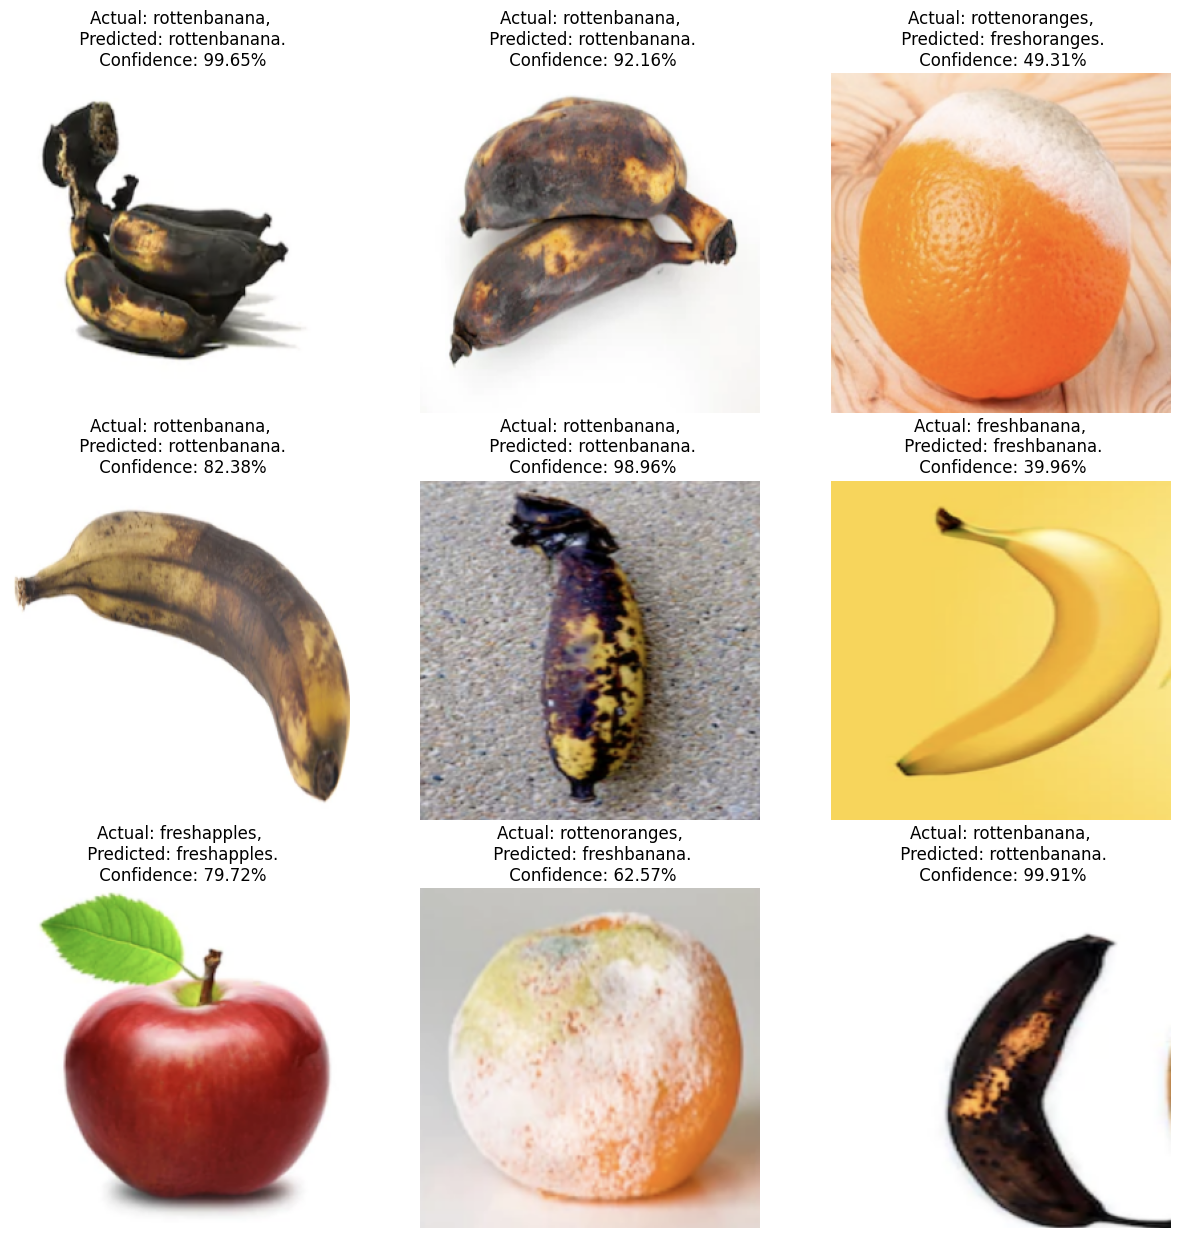

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicated_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicated_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the model
We append the model to the list of models as a new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets


In [ ]:
model.save('models/fruits.h5') ##for backup model h 